#0. Introduction

How can we tell which planet could be Earth's cosmic twin in terms of habitability? Scientists use a parameter known as the Earth Similarity Index, derived from analyzing various planetary characteristics. However, the problem is that the Earth Similarity Index doesn't necessarily determine a planet's ability to support life. In fact, there is no other existing formula that can determine habitability. Thus, the most effective way to predict and rate the habitability of exoplanets from 0% to 100% is by using machine learning techniques like deep learning and neural networks.

In this project, I'm using datasets from the Open Exoplanet Catalogue and the NASA Exoplanet Archive to develop a machine learning model that predicts the degree of similarity between planets and Earth based on other characteristics such as (what are your features). After preprocessing and handling the missing information (described below), I applied PCA to simplify the many factors in the data and then Linear regression as my first technique to determine the accuracy of my predictions for Earth Similiarity within my smaller dataset and predict the Earth Similiarity and habitability ratings of exoplanets within my larger dataset.

Since I wanted to compare my results with a neural network model, I also developed more sophisticated, multi-layered deep learning models to better predict the distribution of exoplanets on the Earth Similarity Index and Habitability scale. My model's performance is highly accurate and reflects the results of habitability within exoplanetary discovery.

In the future, I would like to do machine learning projects and research that explore exoplanet and brown dwarf detection and characterization. I'm also interested in using machine learning and mathematical modeling to further explore the possibility of life on other worlds, meteorological and hydrological patterns, climate change prediction, and artificial recognition of patterns, images, symbols, and other phenomena.

I chose this topic due to my long-time interest in astrophysics and wanted to combine the fields of outer space and machine learning together. Additionally, exploring the Earth Similiarity and Habitability wasn't as deeply explored as I initially thought, so I wanted to create this project in the hopes that it can be expanded upon in the future. Hopefully, this can contribute somehow to the search for life on other worlds in outer space.

#1. Loading My Two Datasets

First, I downloaded two datasets.

The first dataset is my OEC file which stands for *Open Exoplanet Catalogue*. It's a dataset covering over 3,500 exoplanets that contains a variety of data about those exoplanets and the stars they orbit around.

The second dataset is my PSC file which stands for *Planetary Systems Comparison* which comes from the NASA Exoplanet Archive. It's a dataset covering over 5,500 exoplanets that contains even more data columns about planetary and host star characteristics. Due to the similiarity of the two datasets, I was able to easily create models that could work well for both datasets.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk


OEC = pd.read_csv("oec.csv") #OEC stands for Open Exoplanet Catalogue
PSC = pd.read_csv("PSCompPars_2023.09.17_08.49.34.csv")  #PSC stands for Planetary Systems Comparison from the NASA Exoplanet Archive

##Data Sources

[OEC Main Dataset]

[PSC Dataset for Regression Predictions]

[OEC Main Dataset]: https://www.kaggle.com/datasets/mrisdal/open-exoplanet-catalogue

[PSC Dataset for Regression Predictions]: https://www.kaggle.com/datasets/franoisgeorgesjulien/nasa-exoplanet-archive-planetary-systems

#2. Data Pre-Processing

Next, I then went into pre-processing my data, which was mainly centered around droping data columns and filling in missing values.

Due to some of the data columns I'd need for later mostly containing missing values, I set the dropping threshold of NaN values for a column to 0.9 or 90%, so that only columns that were effectively void of anything were dropped.

Next, to deal with the missing values, I decided to set the value to mean of the data. I didn't set it to zero because it wouldn't make sense for a star to be 0 years old and not emit any heat (0 degrees Kelvin) or for a planet to be 0 AU or 0 kilometers away from it's parent star. The nature of the data in both the OEC and PSC csv files revolves around values that need to be far greater than 0 for any intuition or scientific realism to be presented accurately or precisely.

In [ ]:
#Data Pre-Processing for Standard OEC and PSC datasets. I'm dropping/filling in missing values.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

OECCategoryDrop = OEC.select_dtypes(include=['object'])
OEC = OEC.drop(OECCategoryDrop, axis=1)

PSCCategoryDrop = PSC.select_dtypes(include=['object'])
PSC = PSC.drop(PSCCategoryDrop, axis=1)

missing_percent_OEC = (OEC.isna().sum()/ len(OEC))
missing_percent_PSC = (PSC.isna().sum()/ len(PSC))
threshold = 0.9

#Creating Specific Pandas for rows below the threshold of 0.5/50%

#OEC_Temperature = OEC.dropna(subset=['SurfaceTempK']) (Commented out code that is related to the last paragraph in my markdown update below)

#Dropping Columns for General OEC and PSC.

OECThresholdDrop = missing_percent_OEC[missing_percent_OEC > threshold].index
OEC = OEC.drop(OECThresholdDrop, axis=1)

PSCThresholdDrop = missing_percent_PSC[missing_percent_PSC > threshold].index
PSC = PSC.drop(PSCThresholdDrop, axis=1)

#We replaced the NaNs with 0 because that's what  makes the most sense to us. [Note: Alter depending on regression results]
OEC = OEC.fillna(OEC.median())
PSC = PSC.fillna(PSC.median())
#OEC_Temperature = OEC_Temperature.fillna(0) (Commented out code that is related to the last paragraph in my markdown update below)

#Getting rid of scientific notation for future numpy. Showed all numpy rows and columns.

np.set_printoptions(suppress=True, threshold=np.inf)

#3. Feature Engineering and Conversions

## 3.1 Feature Engineering and Conversions - Creating Essential General Planetary Feature Columns


In the last large step in preparing my model, I needed to create datacolumns based on simple unit conversions of existing data columns or based on fundamental astrophysics formulas, such as the formula for escape velocity.

I needed to convert and create measurement units for both data columns due to later steps involving modeling.

Then, I dropped some of the data columns I used in my conversion as I wouldn't need them further and I figured it would improve my later PCA.

In [ ]:
#Creating Future Columns for Data Usage
import numpy as np

# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.10f}'.format


#Converting the Processed OEC Panda into a Numpy. OECN Stands for Open Exoplanet Catalogue Numpy
OEC[["RadiusEarth"]] = OEC[["RadiusJpt"]]*10.973299394820344
OEC[["MassEarth"]] = OEC[["PlanetaryMassJpt"]]*317.89416731

PSC["RadiusEarth"] = PSC[["pl_rade"]]
PSC["MassEarth"] = PSC[["pl_bmasse"]]
PSC["SurfaceTempK"] = PSC["pl_eqt"]
PSC = PSC.drop(columns=["pl_radj","pl_bmassj"])

OEC["VolumeREarth^3"] = (4/3) * np.pi * (OEC["RadiusEarth"] ** 3)
PSC["VolumeREarth^3"] = (4/3) * np.pi * (PSC["RadiusEarth"]  ** 3)

# Calculate density by dividing mass by volume. The units are g/cm^3
OEC["Density"] = OEC["MassEarth"] / OEC["VolumeREarth^3"] * (5.9722*(10**27)/(637100000**3))
PSC["Density"] = PSC["pl_dens"]

#Calculate escape velocity using the formula sqrt(2GM/R)
escape_velocities0 = []
for index, row in OEC.iterrows():
    escape_velocity0 = np.sqrt((2 * (6.6743 * 10**-11) * row["MassEarth"] * (5.9722 * 10**24)) / (6371000* row["RadiusEarth"]))
    escape_velocities0.append(escape_velocity0)

OEC["EscapeVelocity"] = escape_velocities0


escape_velocities1 = []
for index, row in PSC.iterrows():
    escape_velocity1 = np.sqrt((2 * (6.6743 * 10**-11) * row["MassEarth"] * (5.9722 * 10**24)) / (6371000* row["RadiusEarth"]))
    escape_velocities1.append(escape_velocity1)

PSC["EscapeVelocity"] = escape_velocities1
#OEC_TemperatureN = OEC_Temperature.to_numpy() (Commented out code that is related to the last paragraph in my markdown update below)

## 3.2 Feature Engineering and Conversions - Converting Main Pandas into Numpy Arrays

Then, after finishing our initial pre-processing and feature engineering, we convert the OEC and PSC Pandas into Numpy Arrays so that we can perform PCA and modeling.

In [ ]:
#Creating Numpies out of Pandas
#OEC
OECN = OEC.to_numpy()

#PSC
PSCN = PSC.to_numpy()

##3.3 Feature Engineering and Conversions - Performing PCA

In the final step before modeling, we perform PCA on both the OEC and PSC datasets. What is PCA? To put it shortly, it's a process that truncates or simplifies the many data columns we have in our datasets into a few main columns that depict the general trends in our dataset. These new columns are not equal to any of the initial columns we had before, but are instead the result of merging the ones we've had before together.

Here, I've simplified the mutltitude of data columns from the OEC and PSC datasets into 7 PCA columns known as PC1, PC2, $\ldots$, PC7.

This helps with modeling relationships and computations.

In [ ]:
from sklearn.decomposition import PCA

# PCA for OECN
# Create a PCA object with 7 components
pca_OEC = PCA(n_components=7)

# Fit the PCA model to the OECN dataset and transform it
reduced_data_OEC = pca_OEC.fit_transform(OECN)  # for train dataset

# Create column names for the DataFrame
columnnames_OEC = [f'PC{i}' for i in range(1, 8)]

# Create a DataFrame with the reduced data (not reconstructed data)
OECPCA = pd.DataFrame(reduced_data_OEC, columns=columnnames_OEC)

# PCA for PSCN
# Create a new PCA object with 7 components
pca_PSC = PCA(n_components=7)

# Fit the PCA model to the PSCN dataset and transform it
reduced_data_PSC = pca_PSC.fit_transform(PSCN)  # for train dataset

# Create column names for the DataFrame
columnnames_PSC = [f'PC{i}' for i in range(1, 8)]

# Create a DataFrame with the reduced data (not reconstructed data)
PSCPCA = pd.DataFrame(reduced_data_PSC, columns=columnnames_PSC)


#4. Modeling

Now that we've set up everything, the data can be modeled for our two main indexes.

##4 Modeling - Modeling a New Habitability Index

After applying linear regression and deep learning the on Earth Similiarity Index (ESI) values, I wanted to construct a new index (a Planetary Habitability Index) and compare it to the ESI. Thus, I performed research on what such an index could be centered around. From my research, I discovered the following qualities below that scientists have looked for and even asked a formulaic model could be centered around:

- Mass: approximately 2M🜨. **2**
- Radius: to maintain a similar density to Earth, its radius should be close to 1.2 or 1.3R🜨. **1.25**
- Oceans: percentage of surface area covered by oceans should be Earth-like but more distributed, without large continuous land masses. The oceans should be shallow; the light then will penetrate easier through the water and will reach the fauna and flora, stimulating an abundance of life down in the ocean.
- Distance: shorter distance from the center of the habitable zone of the system than Earth.
- Temperature: average surface temperature of about 25 °C (77 °F). **25**[12]
- Star temperature and age: belonging to an intermediate K-type star with an older age than the Sun (4.5 billion years) but younger than 7 billion years.
 **4,550 , 5.75**
- Atmosphere: somewhat denser than Earth's and with a higher concentration of oxygen. That will make life larger and more abundant.


 Due to the limitations of my datasets, I wasn't able to find a way to include ocean surface area into my dataset.  This could be a topic for future use perhaps.
A way to work in the measurement of atmosphere is by using escape velocity. If a planet has a high escape velocity, it's very likely that it can support a dense atmosphere long-term.

Thus, I was left to only work with the planet's mass, radius, surface temperature, escape velocity, and distance from its star as well as the parent star's temperature and age.

###4.1 Modeling - Modeling a New Habitability Index - Linear Regression

Just like before, I used linear regression in my model, in which I combined the old ESI features with a planet's distance (or Semi-Major axis) and its star's age and temperature. I then create a new randomly generated index that would represent the habitability rating of the exoplanets. I then performed linear regression to find out that most values lied very close to or at 0.5. It most likely indicates that it wasn't able to find much of a relationship, since the index is randomly generated. Thus, we'd need to use more than linear regression to find anything substantial.

Mean Squared Error: 0.08326093121388482


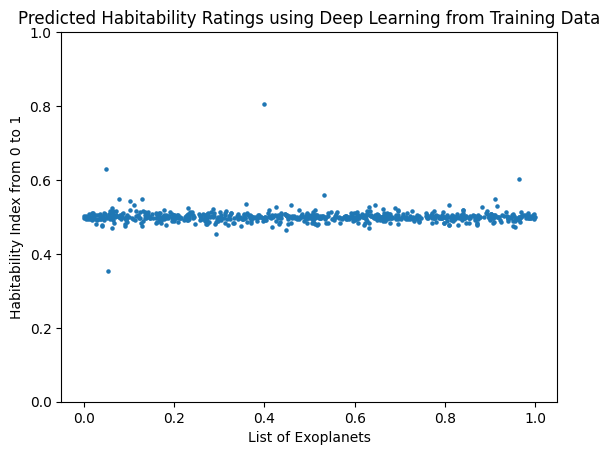

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


esi_features = ["MassEarth","RadiusEarth", "EscapeVelocity", "SurfaceTempK"]
additional_features = ["HostStarTempK", "HostStarAgeGyr", "SemiMajorAxisAU"]

# Generate synthetic data for the target variable 'new_index'
np.random.seed(42)
OEC['new_index'] = np.random.rand(len(OEC))

# Select features (X) and target variable (y)
X = OEC[esi_features + additional_features]
y = OEC['new_index']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Now you can use the trained model to predict the new index for your entire dataset
OEC['predicted_new_index'] = model.predict(X)

# 'predicted_new_index' column now contains the predicted values based on your features
# Plot the predicted ESI ratings
plt.scatter(y_test, y_pred, s=5)
plt.xlabel('List of Exoplanets')
plt.ylabel('Habitability Index from 0 to 1')
plt.ylim(0, 1)
plt.title('Predicted Habitability Ratings using Deep Learning from Training Data')
plt.show()


###4.2 Modeling - Modeling a New Habitability Index - Neural Networks/Deep Learning

This section of modeling has my final model where I use neural networks to get a vast majority of entries with values of around 0.05, showing that the almost all of the planets within the training OEC dataset are inhospitable.

However, there are a couple stragglers that exist between 0.2 and 0.9. There are a few data points that even reach as high as 1.0, suggesting that they have the ideal characteristics for a world able to support life, maybe even more so than Earth itself.

This final model used the earlier mentioned guidepost values that I had researched and treated them as ideal values. If a planet had all of the afforemeantioned ideal values, they would score a 1.0 (100%). The further a planet's qualities were from the perfect numerical values, the lower that planet's score would be. I then included weights for each quality, as some columns are more important for habitability than others are. For example, having a good values for escape velocity and surface temperature is more important than having good values for the age of the star that an exoplanet orbits.

Additionally, I tried to ensure index values less than 0 were turned to 0. I had some trouble doing something similar for positive values greater than 1, which could be a topic for future improvement for this model.

####4.2.1 OEC Training and Fitting Model

This final model used the earlier mentioned guidepost values that I had researched and treated them as ideal values. If a planet had all of the afforemeantioned ideal values, they would score a 1.0 (100%). The further a planet's qualities were from the perfect numerical values, the lower that planet's score would be. I then included weights for each quality, as some columns are more important for habitability than others are. For example, having a good values for escape velocity and surface temperature is more important than having good values for the age of the star that an exoplanet orbits.

This deep learning model consists of 3 non-linear Relu Components followed by the same linear-regression layer that we solely used before in section 4.2.1.

As expected, I found that most entries would center around 0 to 0.2. However, there are some scattered between 0.2 and 0.8. There's even one around 0.9, making that one very habitable!

12/12 [==============================] - 0s 2ms/step
Mean Squared Error: 0.033188214183744756
112/112 [==============================] - 0s 2ms/step


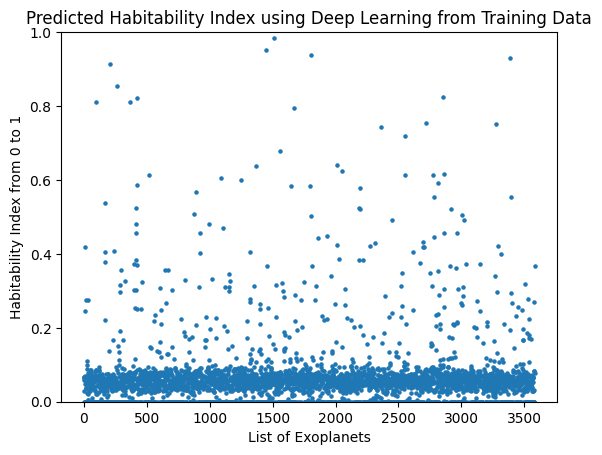

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

# Assuming OEC is your DataFrame
esi_features = ["MassEarth", "RadiusEarth", "EscapeVelocity", "SurfaceTempK"]
additional_features = ["HostStarTempK", "HostStarAgeGyr", "SemiMajorAxisAU"]

#Below are the ideal or target values which are meant to show the approximate values a planet should contain in order to still be habitable.
ideal_values = {"MassEarth": 2, "RadiusEarth": 1.25, "EscapeVelocity": 13000,
                "SurfaceTempK": 298, "HostStarTempK": 4550,
                "HostStarAgeGyr": 5.75, "SemiMajorAxisAU": 0.95}

# Define feature weights. These are meant to show how weighted each column and its ideal value are in the habitability index. The gerater the number, the more important that corresponding vairable is in our rating and the closer a factor must be to the target value for the planet to remain sufficiently habitable.
feature_weights = {"MassEarth": 0.9, "RadiusEarth": 0.9, "EscapeVelocity": 1.05,
                   "SurfaceTempK": 1.05, "HostStarTempK": 0.85,
                   "HostStarAgeGyr": 0.75, "SemiMajorAxisAU": 0.75}


# Calculate the distance of each data entry to its corresponding ideal value for each feature
for feature in esi_features + additional_features:
    OEC[f'distance_to_ideal_{feature}'] = np.abs(OEC[feature] - ideal_values[feature])

# Calculate weighted distances for each feature
for feature in esi_features + additional_features:
    OEC[f'weighted_distance_{feature}'] = OEC[f'distance_to_ideal_{feature}'] * feature_weights[feature]

# Sum up the weighted distances for each data entry
OEC['weighted_sum'] = OEC[[f'weighted_distance_{feature}' for feature in esi_features + additional_features]].sum(axis=1)

# Normalize the weighted sum to be between 0 and 1 using MinMaxScaler
min_max_scaler = MinMaxScaler()
OEC['normalized_weighted_sum'] = min_max_scaler.fit_transform(OEC['weighted_sum'].values.reshape(-1, 1))

# Apply logarithmic transformation to values greater than 1
OEC['normalized_weighted_sum'] = np.where(OEC['normalized_weighted_sum'] > 1, np.log1p(OEC['normalized_weighted_sum']), OEC['normalized_weighted_sum'])

# Set values less than 0 to 0
OEC['normalized_weighted_sum'] = np.where(OEC['normalized_weighted_sum'] < 0, 0, OEC['normalized_weighted_sum'])

# Select features (X) and target variable (y)
X = OEC[esi_features + additional_features]
y = OEC['normalized_weighted_sum'].values.reshape(-1, 1)  # Reshape to ensure it is a 2D array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Use RobustScaler instead of StandardScaler. This is to help fit the data within the range from 0 (0%) to 1 (100%)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a neural network with increased complexity and different activations
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  #This 1st Relu Activation Layer is a non-linear component of our neural network, making our deep learning model unable to be substituted by a mathematical formula.
    layers.Dense(64, activation='relu'),  #This 2nd Relu Activation Layer is a non-linear component of our neural network, making our deep learning model unable to be substituted by a mathematical formula.
    layers.Dense(32, activation='relu'),  #This 3rd Relu Activation Layer is a non-linear component of our neural network, making our deep learning model unable to be substituted by a mathematical formula.
    layers.Dense(1, activation='linear') #This is the linear-regression layer, which represents the first lienar-regression models we did for habitability in section 4.2.1
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.25, verbose=0)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Set predicted values less than 0 to 0
y_pred = np.where(y_pred < 0, 0, y_pred)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Now you can use the trained neural network to predict the habitability index for your entire dataset
OEC['predicted_habitability_index'] = model.predict(scaler.transform(X))

# Set predicted values less than 0 to 0
OEC['predicted_habitability_index'] = np.where(OEC['predicted_habitability_index'] < 0, 0, OEC['predicted_habitability_index'])

# Plot the actual vs predicted values with the greatest plotted value being 1 and the lowest plotted value being 0.
plt.scatter(range(len(OEC['predicted_habitability_index'])), OEC['predicted_habitability_index'], s=5)
plt.xlabel('List of Exoplanets')
plt.ylabel('Habitability Index from 0 to 1')
plt.ylim(0, 1)
plt.title('Predicted Habitability Index using Deep Learning from Training Data')
plt.show()


After fitting and creating my Habitability model, I (as I've done before), apply it to my larger dataset. I first convert the names of some of my columns so that they're accepted by the model (the values of those columns are the same) and then predict my data. The x-axis represents a list of exoplanet datapoints while the y-value represents each of their habitability values. My data centers at around 0.25 with large variability, resulting in many points containing values above 0.6.

This appears to be moderately realistic, since the vast majority of extrasolar planets aren't habitable. Meanhwhile, as shown by the model here too, there are a decent number of planetary candidates that are habitable.

####4.2.2 Applying Deep Learning from OEC to PSC

Now applying the model to a larger dataset, I find a very large distribution of data. However, the majority of data is still centered between 0.0 and 0.3, reaffirming that most planets detected are not habitable. However, there are many more entries from 0.3 to 0.6 and 0.6 to 1.0, showing that, based on this model, there are also a great number of exoplanets that could claim to support life as we know it.

173/173 [==============================] - 0s 2ms/step


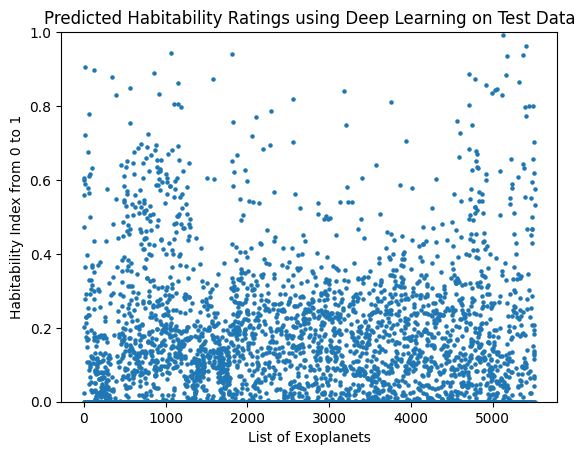

In [ ]:
# Assuming model is your trained neural network model
# Assuming scaler is your trained StandardScaler

PSC["MassEarth"] = PSC["pl_bmasse"]
PSC["HostStarTempK"] = PSC["st_teff"]
PSC["SemiMajorAxisAU"] = PSC["pl_orbsmax"]
PSC['HostStarAgeGyr'] = np.random.normal(loc=4.5, scale=2 * 4.5, size=len(PSC))



# Define the features for prediction in the PSC dataset
esipsc_features = ["MassEarth","RadiusEarth", "EscapeVelocity", "SurfaceTempK"]
additional_features = ["HostStarTempK", "HostStarAgeGyr", "SemiMajorAxisAU"]
X_PSC = PSC[esipsc_features + additional_features]

# Standardize the features using the same scaler used for training
X_PSC_scaled = scaler.transform(X_PSC)

# Predict the 'new_index' for the PSC dataset
PSC['predicted_new_index_nn'] = model.predict(X_PSC_scaled)

# Set predicted values less than 0 to 0
PSC['predicted_new_index_nn'] = np.where(PSC['predicted_new_index_nn'] < 0, 0, PSC['predicted_new_index_nn'])

# Plot the actual vs predicted values
plt.scatter(range(len(PSC['predicted_new_index_nn'])), PSC['predicted_new_index_nn'], s=5)
plt.xlabel('List of Exoplanets')
plt.ylabel('Habitability Index from 0 to 1')
plt.ylim(0, 1)
plt.title('Predicted Habitability Ratings using Deep Learning on Test Data')
plt.show()


In [ ]:
#Calculating the mean, median, and standard deviation of Habitability ratings for the exoplanet entries above based on Deep Learning!
mean_prediction = np.mean(PSC['predicted_new_index_nn']) #calculating predicted mean
median_prediction = np.median(PSC['predicted_new_index_nn']) #calculating predicted median
std_deviation = np.std(PSC['predicted_new_index_nn']) #calculating predicted standard deviation

print("Mean Prediction:", mean_prediction)
print("Median Prediction:", median_prediction)
print("Standard Deviation of Predictions:", std_deviation)

Mean Prediction: 0.14710474
Median Prediction: 0.0027685608
Standard Deviation of Predictions: 0.73086643


#5. Conclusion

From the computations and research performed, we have loaded two large files from Kaggle (which ultimately originated from NASA), pre-processed our data, added new columns, and did PCA.

From there, we took our OEC dataset and used deep learning on our OEC dataset (as well as linear regression) to ultimately create a model for the habitability of exoplanets, which got applied to our PSC csv file too.

The results for both of these were sound and were reflective of the broad trends in exoplanetary astronomy and astrophysics. Hopefully this code can inspire future projects that expand on the work done here and make even better models.

Here are some notes about areas of potential improvement

- Models that can even more realistically account for outliers that may end up beyond 0 and 1 while not seriously affecting the data between 0 and 1.
- The inclusion of oceans within the habitability index and datasets.
- Using these models to name the planets with a habitability rating at least above 0.6.
- Doing more research into the weights of the categories used for the new habitability index to provide more accurate weights in future research.
- Overall making more improvements to make the training and testing data for deep learning for the habitability index more accurate!


#6. Updates

##Update 1: October 30th
So far in my project, I've cleaned and preprocessed my test data. I've also done PCA on that data as possible preparation to train it for potential new exoplanet data. In addition, I created mini-datasets based off of two arbitraily picked columns from the original OEC.csv.

I was thinking of examining the relationship of these variables as a potential start for this next week. If I don't follow through with that, I might attempt to perform linear regression and analysis on the data to examine how closely exoplanets may relate to each other. If I find neural networks and deep learning fascinating, I might also pursue that route as well.

Besides that, there were some columns that did have a lot of NaN values that I'd like to include into the OECN numpy like surface temperature, mass and orbital distance. I'm just unsure of whether I should fill those NaN values with 0 or if I should try something else.

##Update 2: November 6th
So far in my project, I've cleaned and preprocessed my test data by filling NaN values with the mean value of the column they reside in. I've also done PCA on that data as possible preparation to train it for potential new exoplanet data and to eliminate excess values such as the qualities of the exoplanets' host stars. In addition, I created mini-datasets based off of two arbitraily picked columns from the original OEC.csv. I've decided to fill my NaN values with the mean values in the data frame.

From there, I've created new columns for density and escape velocity and used those to calculate ESI (Earth Similarity Index; [1]) for every registered exoplanet on a scale between 0 or 0% (completely different from Earth) to 1 or 100% (completely identical to Earth). From there, I performed linear regression to prove that the difference between the true ESI data calculated using formulas and the predicted ESI data based on regression modeling is accurate.

From here, I'm thinking that I might use linear regression for new exoplanets to predict and recommend the simliarity between those planets and Earth. I might also look into ways to incorporate other characterisitcs to define and scale habitability rather than Earth similiarity and see how they compare. Another idea I had was to incorporate deep learning into my model somehow and find out what I can do with it.



[1]: https://en.wikipedia.org/wiki/Earth_Similarity_Index

##Update 3: November 13th

I added a new dataset for the project: 🌎 NASA Exoplanet Archive - Planetary Systems [2], which I dubbed "PSC". This set has more objects then my first dataset and is almost twice as large, so I thought that it would be perfect for linear regression predictions. So, I preprocessed my PSC datafile, cleaned it, did PCA, and used my linear regression from my OEC datafile on the PSC.

The main issue I'm trying to solve is that the linear regression results look somewhat off from my results from my trained data. I've also been examining something known as PHI/SEPHI (Planetary Habitability Index [3]). I have the hope of possibly coding it for my OEC dataset and comparing it and the ESI column.

I also am trying to find how I can incorporate neural netwroks and deep learning into my project. It will be great to learn how I can use neural networks in programming so I can integrate it here!

[2]: https://www.kaggle.com/datasets/franoisgeorgesjulien/nasa-exoplanet-archive-planetary-systems

[3]: https://academic.oup.com/mnras/article/471/4/4628/4096396

##Update 4: December 4th

I've constructed a linear regression model, simple neural networks, and more complex neural network models for a new habitability index based on certain parameters that isn't defined through an equation [4]. The parameters contain old variables from the Earth Similarity Index but there are also new variables included. So far, the complex neural network has been the most sucessful since the data is the most scattered. However, I was expecting that the values of most objects would be close to 0 rather than at 0.5.

I'm wondering if it could be due to the way I've filled in missing values for some data columns (ex. one column, "HostStarAgeGyr", only has one entry that has made every other row of that column contain that same value. Maybe it would be better to add some level of variation to make things more realistic.

[4]: https://en.wikipedia.org/wiki/Superhabitable_planet#Profile_summary

##Update 5: December 15th

I finally was able to construct a complex deep learning model for the OEC dataset that gave a realistic prediciton of what exoplanetary habitability would most be like for the exoplanetary data recorded. Then, I was able to apply that model to the larger PSC dataset by creating corresponding data columns that the model would accept, which I'm satisfied with overall due to the spread of data being realistic and it covering much of the range between 0 (0%) and 1 (100%).

A couple areas of improvement from what I've created was the exclusion of the presence of water on planetary bodies. I was unsure what I could do to possibly measure whether $H_2O$ may exist on certain celestial bodies and if there's a way of including that for the OEC training and PSC testing sections, that would only improve the model further!

Other ideas I was thinking of including but didn't necessarily have the time to do included possible using machine learning to fill in gaps within data.